## Table of Contents

* 1. [Data Loading](#dataloading)
    * 1.1 [Libraries](#libs)
    * 1.2 [Load CSV](#loadcsv)
* 2. [Basic Data Preprocessing and EDA](#preprocessing)
    * 2.1 [Train Dataset](#traindata)
        * 2.1.1 [Numerical Features](#trnum)
            * 2.1.1.1 [Missing Values](#nummisvals)
            * 2.1.1.2 [Quasi Constant Check](#quasiconst)
            * 2.1.1.3 [Category Change](#trnewcat)
        * 2.1.2 [Categorical Features](#trcat)
        * 2.1.3 [Simplification of Features](#freqcat)
        * 2.1.4 [Label Encoding/Factorizing](#encvals)
        * 2.1.5 [Outlier Removal](#outl)
    * 2.2 [Test Dataset](#testdata)
        * 2.2.1 [Numerical Features](#trnum)
            * 2.2.1.1 [Missing Values](#testnummisvals)
            * 2.2.1.2 [Quasi Constants Check](#testquasiconst) 
            * 2.2.1.3 [Category Change](#testnewcat) 
        * 2.2.2 [Categorical Features](#testcat)
            * 2.2.2.1 [Missing values](#testcatmisvals)
        * 2.2.3 [Simplification of Features](#testfreqcat)
        * 2.2.4  [Label encoding/factorizing](#testencvals)
        * 2.2.5  [Feature Importance](#ftimp)
* 3. [Modeling](#modeling)
    * 3.1 [Parameter Finetuning](#paramft)
        * 3.1.1 [Random Forest](#rf)
        * 3.1.2 [Perceptron](#pr)
        * 3.1.3 [Support Vector Machines](#svc)
        * 3.1.4 [Linear Support Vector Machines](#linsvc)
        * 3.1.5 [KNN](#knn)
        * 3.1.6 [Stochastic Gradient Descent](#sgd)
        * 3.1.7 [Decision Tree](#dt)
        * 3.1.8 [Gaussian Naïve Bayes](#nb)
        * 3.1.9 [Logistic Regression](#lr)
        * 3.1.10 [Ensemble](#ens)

In [738]:
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading <a class="anchor" id="dataloading"></a>

### 1.1 Libraries<a class="anchor" id="libs"></a>

In [739]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from scipy.stats import shapiro, boxcox
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### 1.2 Load data from files <a class="anchor" id="loadcsv"></a>

In [740]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
print('There are', len(train_df), 'training samples.')
print('There are', len(test_df), 'testing samples.')

There are 891 training samples.
There are 418 testing samples.


In [741]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [742]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [743]:
train_df = train_df.drop(columns=['PassengerId'])
test_id_col = test_df['PassengerId'].tolist()
test_df = test_df.drop(columns=['PassengerId'])

## 2. Basic Data Preprocessing and EDA <a class="anchor" id="preprocessing"></a>

### 2.1 Preprocessing of the Training Dataset <a class="anchor" id="traindata"></a>

### 2.1.1 Numerical Features <a class="anchor" id="trnum"></a>  
We separate numerical features from categorical in order to preprocess them separately.

In [744]:
train_df_num = train_df.select_dtypes(include=[np.number])
train_df = train_df.drop([col for col in train_df_num], axis = 1)
train_df_num.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


#### Check for negative values

In [745]:
print((train_df_num < 0).any())

Survived    False
Pclass      False
Age         False
SibSp       False
Parch       False
Fare        False
dtype: bool


#### 2.1.1.1 Missing values (NaNs) <a class="anchor" id="nummisvals"></a> 
Let's find all missing values (NaNs) in all columns and think about the proper way to deal with those values.

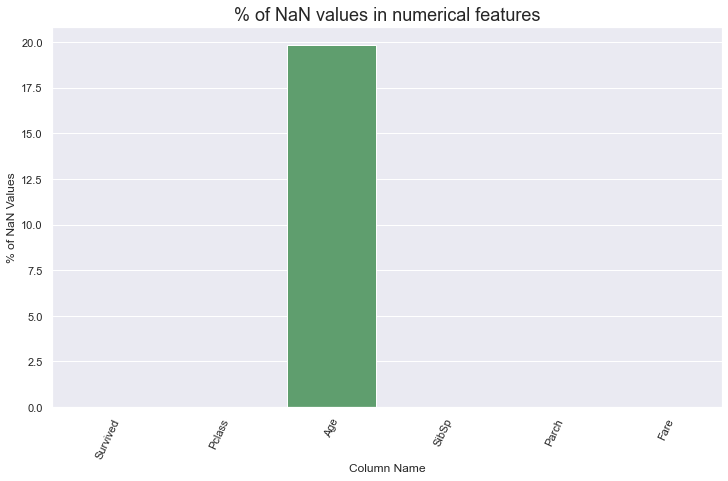

In [746]:
percent_missing_nans = train_df_num.isnull().sum() * 100 / len(train_df_num)
nans = pd.DataFrame({'col_name': train_df_num.columns, 'percent_missing': percent_missing_nans})

sns.set(rc={'figure.figsize':(12,7)})
cols = list(nans['col_name'])
percent = list(nans['percent_missing'])
plt.gca().set_ylabel('% of NaN Values', fontsize = 12)
plt.gca().set_xlabel('Column Name')
plt.title('% of NaN values in numerical features', fontsize = 18)
sns.barplot(x = cols, y = percent)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 65)
plt.show()

In [747]:
nans = nans.reset_index(drop = True)
missing_vals_cols = nans[nans['percent_missing'] != 0]
missing_vals_cols

,col_name,percent_missing
2,Age,19.86532


In [748]:
# Full dataframe of both categorical and numerical features
full_data_temp = pd.concat([train_df, train_df_num], axis = 1)

#### Age feature
Age feature has about 20% of missing values. Let's see if those values are missing at random, or there is a pattern that we can recognize and use this information to impute those values.

In [749]:
age_missed = full_data_temp[full_data_temp['Age'].isnull()]

In [750]:
age_missed

,Name,Sex,Ticket,Cabin,Embarked,Survived,Pclass,Age,SibSp,Parch,Fare
5,"Moran, Mr. James",male,330877,NaN,Q,0,3,NaN,0,0,8.4583
17,"Williams, Mr. Charles Eugene",male,244373,NaN,S,1,2,NaN,0,0,13.0000
19,"Masselmani, Mrs. Fatima",female,2649,NaN,C,1,3,NaN,0,0,7.2250
26,"Emir, Mr. Farred Chehab",male,2631,NaN,C,0,3,NaN,0,0,7.2250
28,"O'Dwyer, Miss. Ellen ""Nellie""",female,330959,NaN,Q,1,3,NaN,0,0,7.8792
...,...,...,...,...,...,...,...,...,...,...,...
859,"Razi, Mr. Raihed",male,2629,NaN,C,0,3,NaN,0,0,7.2292
863,"Sage, Miss. Dorothy Edith ""Dolly""",female,CA. 2343,NaN,S,0,3,NaN,8,2,69.5500
868,"van Melkebeke, Mr. Philemon",male,345777,NaN,S,0,3,NaN,0,0,9.5000
878,"Laleff, Mr. Kristo",male,349217,NaN,S,0,3,NaN,0,0,7.8958


Looks like values in Age are missing at random, so we can't really use logic here impute those values. We can try to fill them using KNN and MICE and see if this will change the original distribution of the Age data. If it won't then we will stick with one of these imputation methods and continue preprocessing. Otherwise, we will need to drop the feature.

#### KNN imputation
KNN imputation is a technique based on the K-Nearest Neighbours algorithm to find similarities across columns.  
We apply KNN imputation to the whole dataset as this is the only possible way to use KNN. Therefore, we expect the imputation method to fill all NaNs in all columns, but we are interested in Age only. 

In [751]:
imputer = KNNImputer(n_neighbors = 5, weights='distance', metric='nan_euclidean')
train_features_imputed = pd.DataFrame(imputer.fit_transform(train_df_num.loc[:, train_df_num.columns != 'Survived']))
train_features_imputed.columns = train_df_num.loc[:, train_df_num.columns != 'Survived'].columns

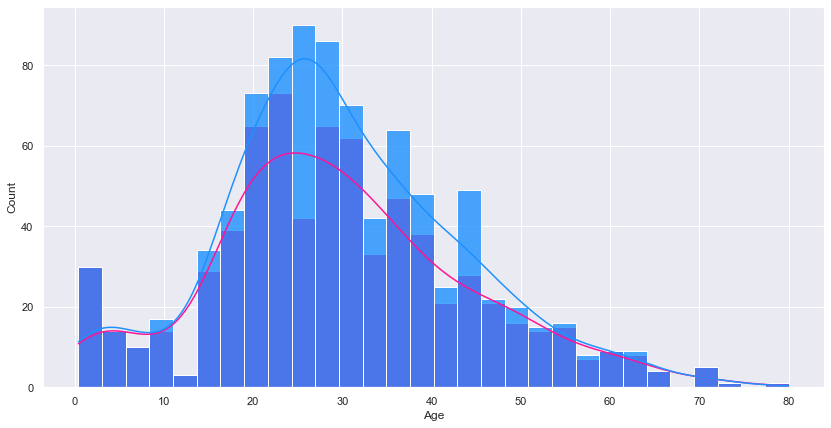

In [752]:
sns.set(rc={"figure.figsize": (14, 7)})
sns.histplot(x = train_df_num['Age'], kde = True, bins = 30, color = 'deeppink', alpha = 1)
sns.histplot(x = train_features_imputed['Age'], kde = True, bins = 30, color = 'dodgerblue', alpha = 0.8)
plt.show()

MICE imputation is a Multivariate Imputation by the Chained Equations iterative data imputation method. In this algorithm, a chain of regression equations is used to obtain imputations, which means that variables with missing data are imputed one by one.

In [753]:
lr = LinearRegression()
imputer = IterativeImputer(estimator = lr, missing_values = np.nan, max_iter = 10, verbose = 2, imputation_order = 'roman', random_state = 0)
train_features_imputed = pd.DataFrame(imputer.fit_transform(train_df_num.loc[:, train_df_num.columns != 'Survived']), columns = train_features_imputed.columns)
train_features_imputed.columns = train_df_num.loc[:, train_df_num.columns != 'Survived'].columns

[IterativeImputer] Completing matrix with shape (891, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.00
[IterativeImputer] Change: 36.39923585239784, scaled tolerance: 0.5123292 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.01
[IterativeImputer] Change: 0.0, scaled tolerance: 0.5123292 
[IterativeImputer] Early stopping criterion reached.


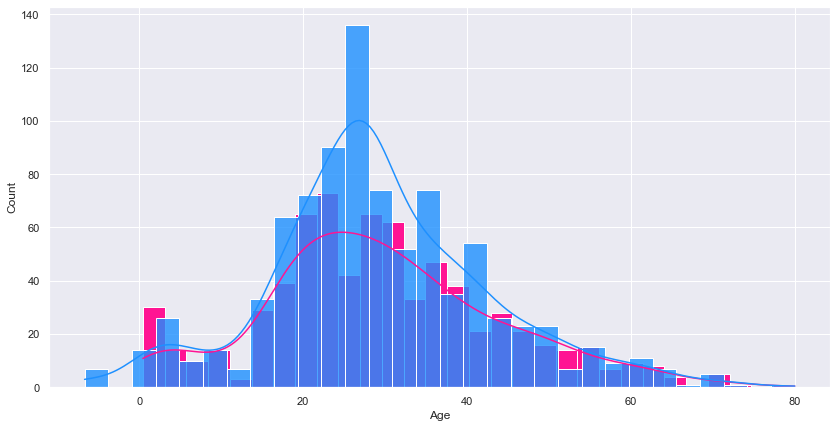

In [754]:
sns.set(rc={"figure.figsize": (14, 7)})
sns.histplot(x = train_df_num['Age'], kde = True, bins = 30, color = 'deeppink', alpha = 1)
sns.histplot(x = train_features_imputed['Age'], kde = True, bins = 30, color = 'dodgerblue', alpha = 0.8)
plt.show()

We can see that after applying KNN first and then MICE imputation, the distribution of Age has changed a lot. Therefore, we won't consider Age as a predictor since we could not fix the missing values.

In [755]:
train_df_num = train_df_num.drop(columns=['Age'])

In [756]:
train_df_num.head()

,Survived,Pclass,SibSp,Parch,Fare
0,0,3,1,0,7.2500
1,1,1,1,0,71.2833
2,1,3,0,0,7.9250
3,1,1,1,0,53.1000
4,0,3,0,0,8.0500


Meanwhile, we will do another experiment and drop all rows where Age values are missing. Then we will use this dataset for training as well.

In [757]:
train_df_reduced = full_data_temp[full_data_temp['Age'].notna()]
train_df_reduced

,Name,Sex,Ticket,Cabin,Embarked,Survived,Pclass,Age,SibSp,Parch,Fare
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S,0,3,22.0,1,0,7.2500
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,1,1,38.0,1,0,71.2833
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S,1,3,26.0,0,0,7.9250
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,1,1,35.0,1,0,53.1000
4,"Allen, Mr. William Henry",male,373450,NaN,S,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...,...,...
885,"Rice, Mrs. William (Margaret Norton)",female,382652,NaN,Q,0,3,39.0,0,5,29.1250
886,"Montvila, Rev. Juozas",male,211536,NaN,S,0,2,27.0,0,0,13.0000
887,"Graham, Miss. Margaret Edith",female,112053,B42,S,1,1,19.0,0,0,30.0000
889,"Behr, Mr. Karl Howell",male,111369,C148,C,1,1,26.0,0,0,30.0000


Let's check again if we eliminated all NaNs in numerical columns in our reduced training dataset.

In [758]:
percent_missing_nans = train_df_reduced.isnull().sum() * 100 / len(train_df_num)
nans = pd.DataFrame({'col_name': train_df_reduced.columns, 'percent_missing': percent_missing_nans})
nans = nans.reset_index(drop = True)
missing_vals_cols = nans[nans['percent_missing'] != 0]
missing_vals_cols

,col_name,percent_missing
3,Cabin,59.371493
4,Embarked,0.224467


Yes, there are no numerical columns with missing values here.

#### 2.1.1.2 Quasi Constants Check <a class="anchor" id="quasiconst"></a> 

In [759]:
""" threshold = 0.05 means 95% of the values are constant
with thresholds < 0.05 i.e. 96% and above, no such columns where detected """

vt = VarianceThreshold(threshold = 0.05)
vt.fit(train_df_num.iloc[:,])

print(f"Number of features left: {sum(vt.get_support())}")
t_quasi_constant_features = [x for x in train_df_num.iloc[:, :-1].columns if x not in train_df_num.iloc[:,].columns[vt.get_support()]]
print(f"Number of quasi constant features to be dropped: {t_quasi_constant_features}")
#test_df_num = test_df_num.drop(t_quasi_constant_features, axis = 1)

Number of features left: 5
Number of quasi constant features to be dropped: []


No quasi-constant features were found among numerical variables.

#### 2.1.1.3 Category Change <a class="anchor" id="trnewcat"></a> 
Features such as the PassengerId, Survived, and Pclass are categorical, therefore, we will assign a corresponding type to those.
Other features such as SibSp, Parch, and Fare are numerical, therefore, we will assign a corresponding type to those.

In [760]:
for col in [['Survived','Pclass']]:
    train_df_num[col] = train_df_num[col].astype('object')
    train_df_reduced[col] = train_df_reduced[col].astype('object')

In [761]:
train_df_num.dtypes

Survived     object
Pclass       object
SibSp         int64
Parch         int64
Fare        float64
dtype: object

In [762]:
train_df_reduced.dtypes

Name         object
Sex          object
Ticket       object
Cabin        object
Embarked     object
Survived     object
Pclass       object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
dtype: object

A very interesting thing we notice in the full dataset is that Age is actually of float64 type, which means that some value or values are float in this column. Let's check that.

In [763]:
train_df_reduced['Age'].value_counts().sort_index()

0.42     1
0.67     1
0.75     2
0.83     2
0.92     1
        ..
70.00    2
70.50    1
71.00    2
74.00    1
80.00    1
Name: Age, Length: 88, dtype: int64

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

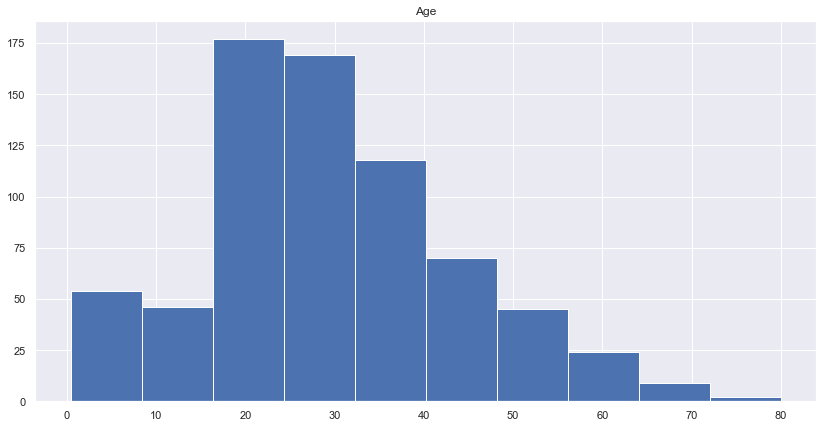

In [764]:
train_df_reduced.hist(column='Age')

We see that Age is supposed to be in years, but we observe some values like 0.42, which does not look like a year or even a month. We will do some feature engineering on that predictor later which would possibly give us more meaningful insights and results. 

In [765]:
train_df = pd.concat([train_df, train_df_num], axis = 1)
train_df.head()

,Name,Sex,Ticket,Cabin,Embarked,Survived,Pclass,SibSp,Parch,Fare
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S,0,3,1,0,7.2500
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,1,1,1,0,71.2833
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S,1,3,0,0,7.9250
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,1,1,1,0,53.1000
4,"Allen, Mr. William Henry",male,373450,NaN,S,0,3,0,0,8.0500


In [766]:
train_df_reduced.head()

,Name,Sex,Ticket,Cabin,Embarked,Survived,Pclass,Age,SibSp,Parch,Fare
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S,0,3,22.0,1,0,7.2500
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,1,1,38.0,1,0,71.2833
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S,1,3,26.0,0,0,7.9250
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,1,1,35.0,1,0,53.1000
4,"Allen, Mr. William Henry",male,373450,NaN,S,0,3,35.0,0,0,8.0500


### 2.1.2 Categorical Features <a class="anchor" id="trcat"></a>  
We separate categorical features from numerical in order to preprocess them separately.

In [767]:
train_df_cat = train_df.select_dtypes(include=[object])
train_df = train_df.drop([col for col in train_df_cat], axis = 1)
train_df_cat

,Name,Sex,Ticket,Cabin,Embarked,Survived,Pclass
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S,0,3
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,1,1
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S,1,3
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,1,1
4,"Allen, Mr. William Henry",male,373450,NaN,S,0,3
...,...,...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S,0,2
887,"Graham, Miss. Margaret Edith",female,112053,B42,S,1,1
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S,0,3
889,"Behr, Mr. Karl Howell",male,111369,C148,C,1,1


#### 2.1.2.1 Missing values (NaNs) <a class="anchor" id="catmisvals"></a> 
Let's find all missing values (NaNs) in all columns and think about the proper way to deal with those values.

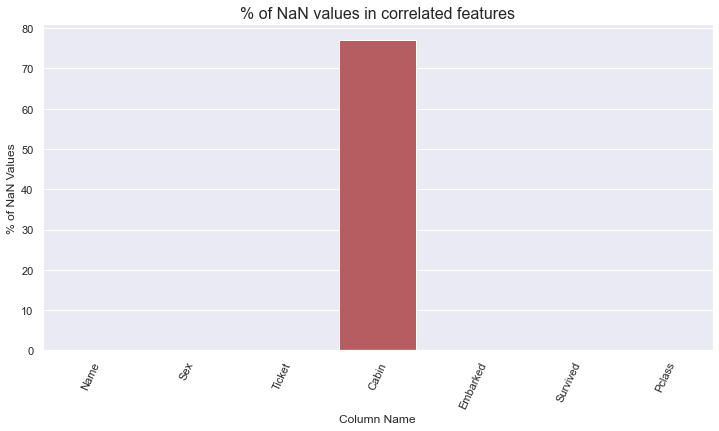

In [768]:
percent_missing_nans = train_df_cat.isnull().sum() * 100 / len(train_df_cat)
nans = pd.DataFrame({'col_name': train_df_cat.columns, 'percent_missing': percent_missing_nans})

sns.set(rc={'figure.figsize':(12,6)})
cols = list(nans['col_name'])
percent = list(nans['percent_missing'])
plt.gca().set_ylabel('% of NaN Values', fontsize = 12)
plt.gca().set_xlabel('Column Name')
plt.title('% of NaN values in correlated features', fontsize = 16)
sns.barplot(x = cols, y = percent)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 65)
plt.show()

In [769]:
nans = nans.reset_index(drop = True)
missing_vals_cols = nans[nans['percent_missing'] != 0]
missing_vals_cols

,col_name,percent_missing
3,Cabin,77.104377
4,Embarked,0.224467


We observe that Cabin has about 77% of missing values, and Embarked has about 0.2% of missing values. In case of the Cabin feature, it's a large percent of missing values and no imputation method would be able to fill all the missing values without changing the distribution. Therefore, we will drop the Cabin feature. In case of Embarked, we will take a look at those whole rows where Embarked is NaN and see how we can fix it.

#### Cabin

In [770]:
train_df_cat.drop('Cabin', axis = 1, inplace=True)
train_df_reduced.drop('Cabin', axis = 1, inplace=True)

#### Embarked

In [771]:
temp = full_data_temp[full_data_temp['Embarked'].isnull()]
temp = temp[['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Survived',
       'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
print('Number of NaN values:', len(temp), '\nPercent of NaN values: {:0.2f}'.format((len(temp)/len(full_data_temp))*100), '%')
temp

Number of NaN values: 2 
Percent of NaN values: 0.22 %


,Name,Sex,Ticket,Cabin,Embarked,Survived,Pclass,Age,SibSp,Parch,Fare
61,"Icard, Miss. Amelie",female,113572,B28,NaN,1,1,38.0,0,0,80.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",female,113572,B28,NaN,1,1,62.0,0,0,80.0


In [772]:
train_df_cat['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

We observe only two rows of where values for Embarked are missing. Also, we see that values of Embarked are S, C and Q, and none of them corresponmds to "Not applicable" so we can't really fill the missing values like that as we may create bias. Also, there are only two rows with missing values of Embarked, and dropping those rows should not cause significant change in the distribution of Embarked.

In [773]:
train_df = pd.concat([train_df, train_df_cat], axis = 1)
train_df = train_df.dropna(subset=['Embarked'])
train_df_reduced = train_df_reduced.dropna(subset=['Embarked'])

In [774]:
train_df

,SibSp,Parch,Fare,Name,Sex,Ticket,Embarked,Survived,Pclass
0,1,0,7.2500,"Braund, Mr. Owen Harris",male,A/5 21171,S,0,3
1,1,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C,1,1
2,0,0,7.9250,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S,1,3
3,1,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S,1,1
4,0,0,8.0500,"Allen, Mr. William Henry",male,373450,S,0,3
...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,"Montvila, Rev. Juozas",male,211536,S,0,2
887,0,0,30.0000,"Graham, Miss. Margaret Edith",female,112053,S,1,1
888,1,2,23.4500,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,S,0,3
889,0,0,30.0000,"Behr, Mr. Karl Howell",male,111369,C,1,1


In [775]:
train_df_reduced

,Name,Sex,Ticket,Embarked,Survived,Pclass,Age,SibSp,Parch,Fare
0,"Braund, Mr. Owen Harris",male,A/5 21171,S,0,3,22.0,1,0,7.2500
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C,1,1,38.0,1,0,71.2833
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S,1,3,26.0,0,0,7.9250
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S,1,1,35.0,1,0,53.1000
4,"Allen, Mr. William Henry",male,373450,S,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...,...
885,"Rice, Mrs. William (Margaret Norton)",female,382652,Q,0,3,39.0,0,5,29.1250
886,"Montvila, Rev. Juozas",male,211536,S,0,2,27.0,0,0,13.0000
887,"Graham, Miss. Margaret Edith",female,112053,S,1,1,19.0,0,0,30.0000
889,"Behr, Mr. Karl Howell",male,111369,C,1,1,26.0,0,0,30.0000


In [776]:
percent_missing_nans = train_df.isnull().sum() * 100 / len(train_df)
percent_missing_nans1 = train_df_reduced.isnull().sum() * 100 / len(train_df_reduced)
nans = pd.DataFrame({'col_name': train_df.columns, 'percent_missing': percent_missing_nans})
nans1 = pd.DataFrame({'col_name': train_df_reduced.columns, 'percent_missing': percent_missing_nans1})

In [777]:
nans

,col_name,percent_missing
SibSp,SibSp,0.0
Parch,Parch,0.0
Fare,Fare,0.0
Name,Name,0.0
Sex,Sex,0.0
Ticket,Ticket,0.0
Embarked,Embarked,0.0
Survived,Survived,0.0
Pclass,Pclass,0.0


In [778]:
nans1

,col_name,percent_missing
Name,Name,0.0
Sex,Sex,0.0
Ticket,Ticket,0.0
Embarked,Embarked,0.0
Survived,Survived,0.0
Pclass,Pclass,0.0
Age,Age,0.0
SibSp,SibSp,0.0
Parch,Parch,0.0
Fare,Fare,0.0


We eliminated all missing values in both training datasets.

### 2.1.3 Simplification of Features and Feature Engineering <a class="anchor" id="freqcat"></a>  
We pursue two tasks here: 1) eliminate all categories with less than 5 observations, 2) eliminate unecessary large number of categories, for examle 5 or 7, if applicable 3) encode features after modifications done according to 1) and 2)

#### Show the frequencies of all categories in each feature

In [779]:
for c in train_df_cat.columns:
    print('--------', c, '--------')
    print(train_df_cat[c].value_counts())

-------- Name --------
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64
-------- Sex --------
male      577
female    314
Name: Sex, dtype: int64
-------- Ticket --------
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64
-------- Embarked --------
S    644
C    168
Q     77
Name: Embarked, dtype: int64
-------- Survived --------
0    549
1    342
Name: Surviv

#### Name

In [780]:
firstName = train_df.Name.str.split(".").str.get(0).str.split(",").str.get(-1)
firstName1 = train_df_reduced.Name.str.split(".").str.get(0).str.split(",").str.get(-1)
firstName.value_counts()

 Mr              517
 Miss            181
 Mrs             124
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Name, dtype: int64

In [781]:
firstName.replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Officer", inplace = True, regex = True)
firstName.replace(to_replace = ["Dona", "Jonkheer", "Countess", "Sir", "Lady", "Don"], value = "Aristocrat", inplace = True, regex = True)
firstName.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace = True, regex = True)
firstName.replace({"the Aristocrat":"Aristocrat"}, inplace = True, regex = True)
train_df["NameNew"] = firstName

In [782]:
firstName1.replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Officer", inplace = True, regex = True)
firstName1.replace(to_replace = ["Dona", "Jonkheer", "Countess", "Sir", "Lady", "Don"], value = "Aristocrat", inplace = True, regex = True)
firstName1.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace = True, regex = True)
firstName1.replace({"the Aristocrat":"Aristocrat"}, inplace = True, regex = True)
train_df_reduced["NameNew"] = firstName1

In [783]:
train_df["NameNew"].value_counts()

 Mr            517
 Miss          184
 Mrs           125
 Master         40
 Officer        18
 Aristocrat      5
Name: NameNew, dtype: int64

In [784]:
train_df_reduced["NameNew"].value_counts()

 Mr            398
 Miss          148
 Mrs           108
 Master         36
 Officer        17
 Aristocrat      5
Name: NameNew, dtype: int64

#### Tickets

In [785]:
train_df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 680, dtype: int64

In [786]:
temp = train_df.Ticket.str.split(" ").str.get(0).str.get(0)
temp1 = train_df_reduced.Ticket.str.split(" ").str.get(0).str.get(0)
train_df["TicketNew"] = np.where(train_df.Ticket.str.isdigit(), "N", temp)
train_df_reduced["TicketNew"] = np.where(train_df_reduced.Ticket.str.isdigit(), "N", temp1)

In [787]:
train_df["TicketNew"].value_counts()

N    659
P     65
S     65
C     47
A     29
W     13
F      7
L      4
Name: TicketNew, dtype: int64

In [788]:
train_df_reduced["TicketNew"].value_counts()

N    519
S     56
P     55
C     39
A     23
W     10
F      6
L      4
Name: TicketNew, dtype: int64

#### SibSp and Parch

In [789]:
train_df["Family"] = train_df.SibSp + train_df.Parch + 1
train_df_reduced["Family"] = train_df_reduced.SibSp + train_df_reduced.Parch + 1

In [790]:
train_df.Family.value_counts()

1     535
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family, dtype: int64

In [791]:
train_df_reduced.Family.value_counts()

1    402
2    139
3     93
4     27
6     22
7     12
5     11
8      6
Name: Family, dtype: int64

In [792]:
train_df.Family.replace(to_replace = [1], value = "single", inplace = True)
train_df.Family.replace(to_replace = [2, 3], value = "small", inplace = True)
train_df.Family.replace(to_replace = [4,5], value = "medium", inplace = True)
train_df.Family.replace(to_replace = [6, 7, 8, 11], value = "large", inplace = True)

In [793]:
train_df_reduced.Family.replace(to_replace = [1], value = "single", inplace = True)
train_df_reduced.Family.replace(to_replace = [2, 3], value = "small", inplace = True)
train_df_reduced.Family.replace(to_replace = [4,5], value = "medium", inplace = True)
train_df_reduced.Family.replace(to_replace = [6, 7, 8, 11], value = "large", inplace = True)

In [794]:
train_df.Family.value_counts()

single    535
small     263
large      47
medium     44
Name: Family, dtype: int64

In [795]:
train_df_reduced.Family.value_counts()

single    402
small     232
large      40
medium     38
Name: Family, dtype: int64

In [796]:
train_df

,SibSp,Parch,Fare,Name,Sex,Ticket,Embarked,Survived,Pclass,NameNew,TicketNew,Family
0,1,0,7.2500,"Braund, Mr. Owen Harris",male,A/5 21171,S,0,3,Mr,A,small
1,1,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C,1,1,Mrs,P,small
2,0,0,7.9250,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S,1,3,Miss,S,single
3,1,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S,1,1,Mrs,N,small
4,0,0,8.0500,"Allen, Mr. William Henry",male,373450,S,0,3,Mr,N,single
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,"Montvila, Rev. Juozas",male,211536,S,0,2,Officer,N,single
887,0,0,30.0000,"Graham, Miss. Margaret Edith",female,112053,S,1,1,Miss,N,single
888,1,2,23.4500,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,S,0,3,Miss,W,medium
889,0,0,30.0000,"Behr, Mr. Karl Howell",male,111369,C,1,1,Mr,N,single


In [797]:
train_df_reduced

,Name,Sex,Ticket,Embarked,Survived,Pclass,Age,SibSp,Parch,Fare,NameNew,TicketNew,Family
0,"Braund, Mr. Owen Harris",male,A/5 21171,S,0,3,22.0,1,0,7.2500,Mr,A,small
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C,1,1,38.0,1,0,71.2833,Mrs,P,small
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S,1,3,26.0,0,0,7.9250,Miss,S,single
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S,1,1,35.0,1,0,53.1000,Mrs,N,small
4,"Allen, Mr. William Henry",male,373450,S,0,3,35.0,0,0,8.0500,Mr,N,single
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,"Rice, Mrs. William (Margaret Norton)",female,382652,Q,0,3,39.0,0,5,29.1250,Mrs,N,large
886,"Montvila, Rev. Juozas",male,211536,S,0,2,27.0,0,0,13.0000,Officer,N,single
887,"Graham, Miss. Margaret Edith",female,112053,S,1,1,19.0,0,0,30.0000,Miss,N,single
889,"Behr, Mr. Karl Howell",male,111369,C,1,1,26.0,0,0,30.0000,Mr,N,single


#### Age in the second training dataset with dropped missing rows
We will make groups of Ages

In [798]:
def age_func(x):
    if x['Age'] <= 2 : return 'baby'
    elif x['Age'] >2 and (x['Age'] <= 16): return 'teenager'
    elif x['Age'] >16 and (x['Age'] <= 30): return 'young adult'
    elif x['Age'] >30 and (x['Age'] <= 45): return 'middle-aged adult'
    elif x['Age'] >45 : return 'old adult'
    else: return 0

train_df_reduced['NewAge'] = train_df_reduced.apply(age_func, axis = 1)

In [799]:
train_df1 = train_df.copy()
train_df_reduced1 = train_df_reduced.copy()
train_df.drop('Name', axis = 1, inplace = True)
train_df.drop('Ticket', axis = 1, inplace = True)
train_df_reduced.drop('Name', axis = 1, inplace = True)
train_df_reduced.drop('Ticket', axis = 1, inplace = True)

### 2.1.4  Label Encoding/Factorizing <a class="anchor" id="encvals"></a> 

In [800]:
class DfLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y = None):
        return self.fit(X,y).transform(X)

In [801]:
train_df_cat = train_df.select_dtypes(include=['object'])
train_df_cat1 = train_df_reduced.select_dtypes(include=['object'])
train_df = DfLabelEncoder(columns = train_df_cat.columns).fit_transform(train_df)
train_df_reduced = DfLabelEncoder(columns = train_df_cat1.columns).fit_transform(train_df_reduced)

In [802]:
for col in [['Sex', 'Embarked', 'Pclass', 'NameNew', 'TicketNew', 'Family', 'SibSp', 'Parch']]:
    train_df[col] = train_df[col].astype('object')

for col in [['Sex', 'Embarked', 'Pclass', 'NameNew', 'TicketNew', 'Family', 'NewAge', 'SibSp', 'Parch']]:
    train_df_reduced[col] = train_df_reduced[col].astype('object')

In [803]:
train_df.dtypes

SibSp         object
Parch         object
Fare         float64
Sex           object
Embarked      object
Survived       int32
Pclass        object
NameNew       object
TicketNew     object
Family        object
dtype: object

In [804]:
train_df_reduced.dtypes

Sex           object
Embarked      object
Survived       int32
Pclass        object
Age          float64
SibSp         object
Parch         object
Fare         float64
NameNew       object
TicketNew     object
Family        object
NewAge        object
dtype: object

### 2.1.5 Outliers Removal <a class="anchor" id="outl"></a>
Outliers are abnormal values in a dataset that don't align with the distribution. These are observations for which the residual is large in magnitude compared to other observations, therefore, outliers tend to skew distributions. Outliers must be carefully investigated and removed only if safe because outliers are not always bad
and sometimes can be helpful and even valuable.

In [805]:
train_df_cols = train_df.columns.tolist()
train_df_reduced_cols = train_df_reduced.columns.tolist()

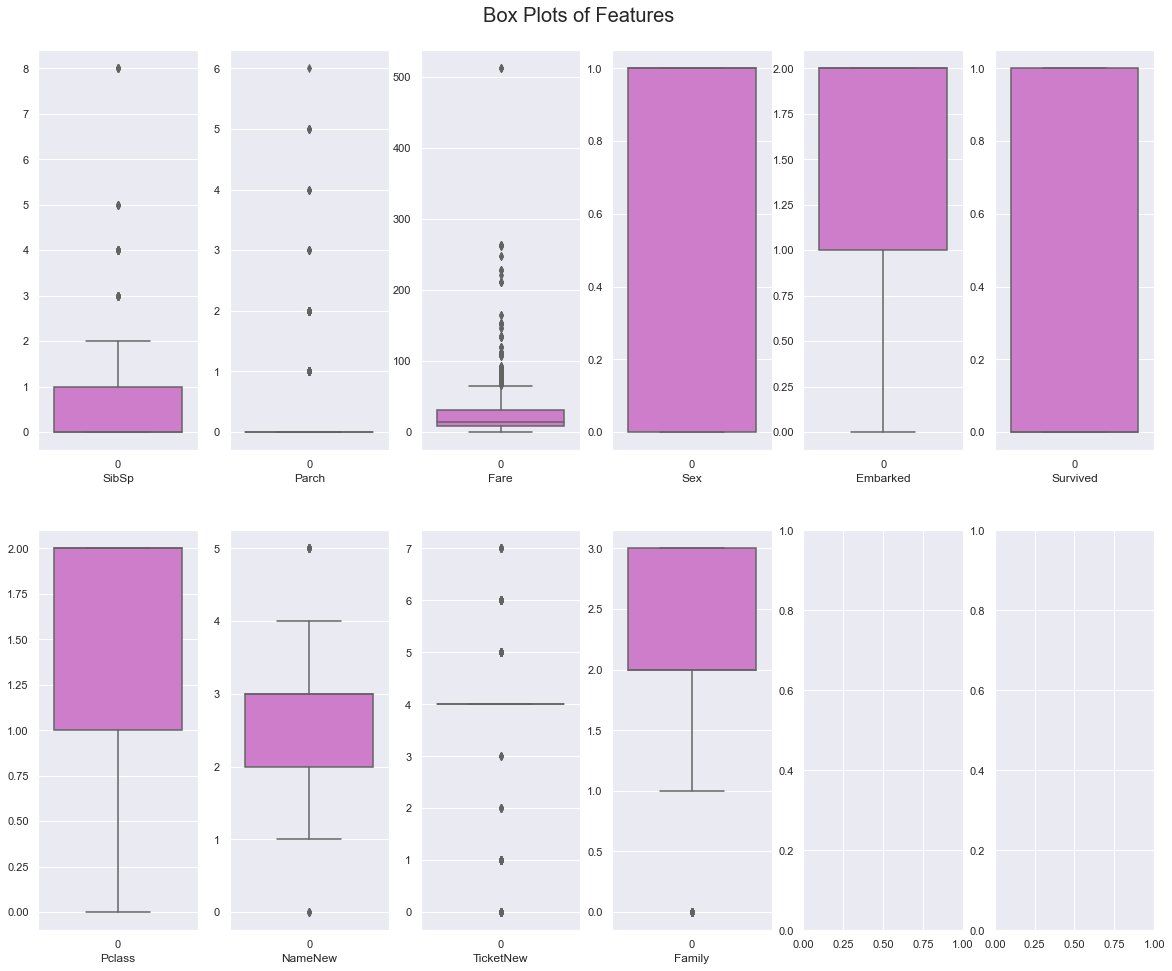

In [806]:
sns.set(rc={'figure.figsize':(20, 15)})
cols = 6
rows = round(train_df.shape[1]/cols)
fig, ax = plt.subplots(rows, cols)
fig.suptitle('Box Plots of Features', fontsize = 20)
fig.subplots_adjust(top = 0.94)
for var, subplot in zip(train_df, ax.flatten()):
    p = sns.boxplot(data = train_df[var], color = 'orchid', ax = subplot)
    p.set_xlabel(var, fontsize = 12)

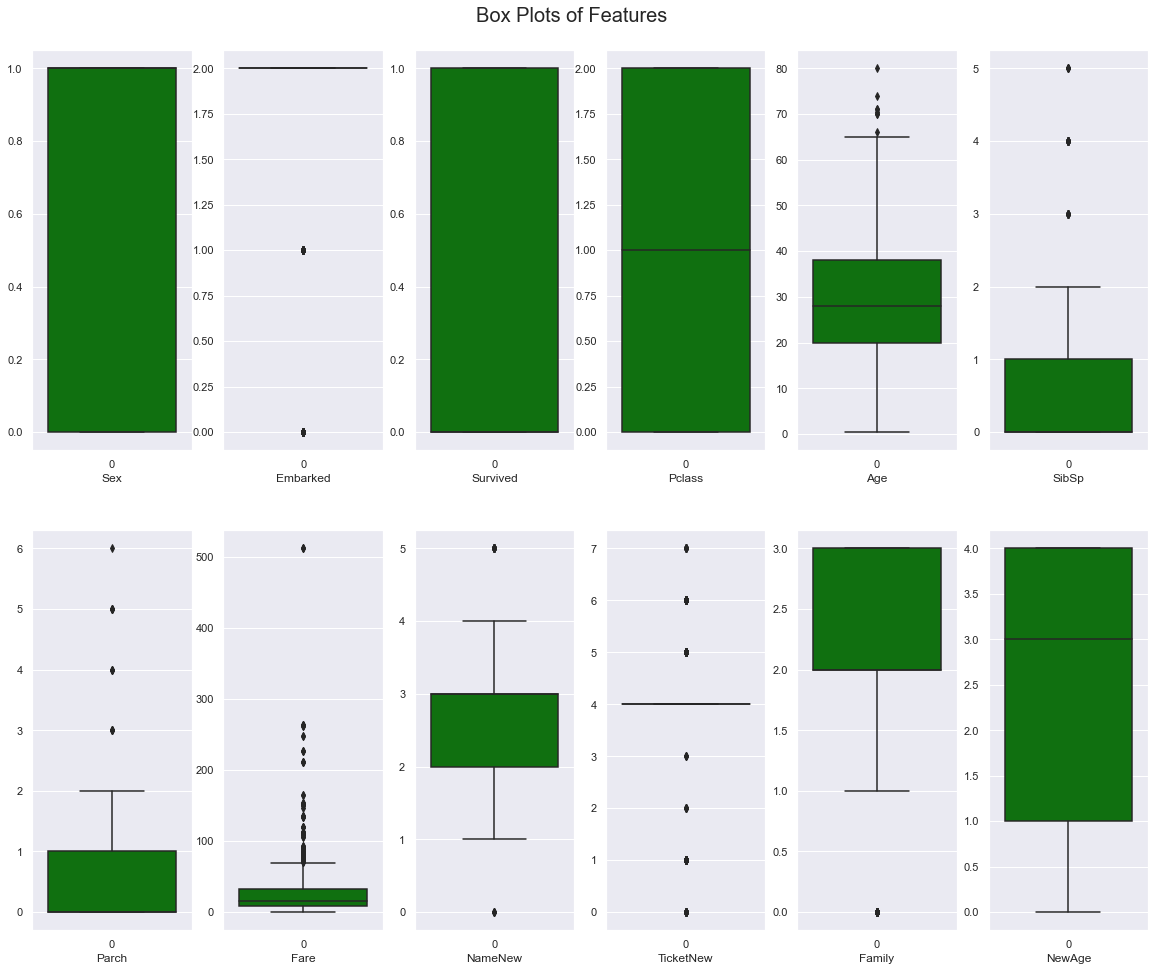

In [807]:
sns.set(rc={'figure.figsize':(20, 15)})
cols = 6
rows = round(train_df_reduced.shape[1]/cols)
fig, ax = plt.subplots(rows, cols)
fig.suptitle('Box Plots of Features', fontsize = 20)
fig.subplots_adjust(top = 0.94)
for var, subplot in zip(train_df_reduced, ax.flatten()):
    p = sns.boxplot(data = train_df_reduced[var], color = 'green', ax = subplot)
    p.set_xlabel(var, fontsize = 12)

In [808]:
train_df_outl = train_df[~((train_df['SibSp'] > 7) | (train_df['Fare'] > 500))]
print('<<<', len(train_df) - len(train_df_outl), 'outliers have been removed >>> ')
train_df_outl = train_df_outl[train_df_cols]

<<< 10 outliers have been removed >>> 


In [809]:
train_df_reduced_outl = train_df_reduced[~((train_df_reduced['Fare'] > 500))]
print('<<<', len(train_df_reduced) - len(train_df_reduced_outl), 'outliers have been removed >>> ')
train_df_reduced_outl = train_df_reduced_outl[train_df_reduced_cols]

<<< 3 outliers have been removed >>> 


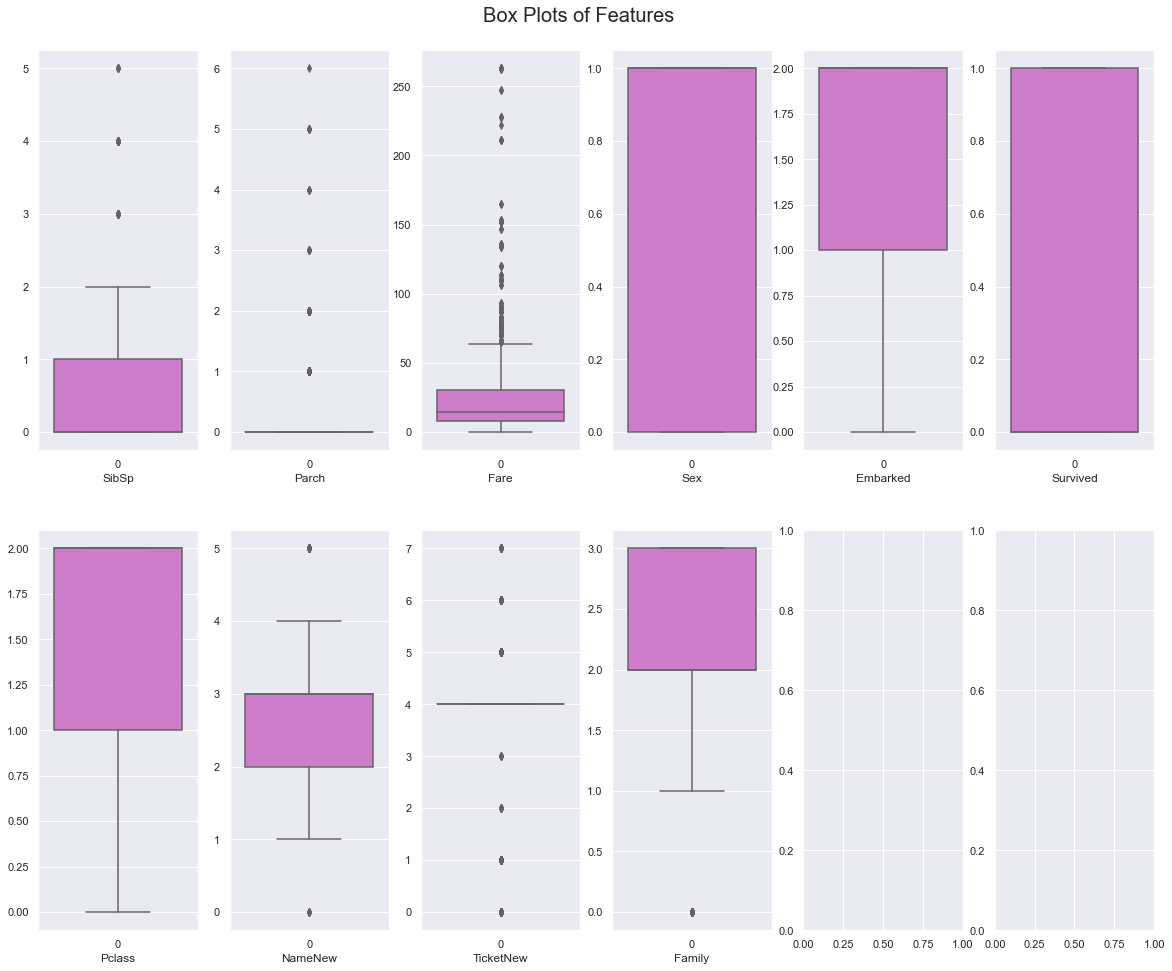

In [810]:
sns.set(rc={'figure.figsize':(20, 15)})
cols = 6
rows = round(train_df_outl.shape[1]/cols)
fig, ax = plt.subplots(rows, cols)
fig.suptitle('Box Plots of Features', fontsize = 20)
fig.subplots_adjust(top = 0.94)
for var, subplot in zip(train_df, ax.flatten()):
    p = sns.boxplot(data = train_df_outl[var], color = 'orchid', ax = subplot)
    p.set_xlabel(var, fontsize = 12)

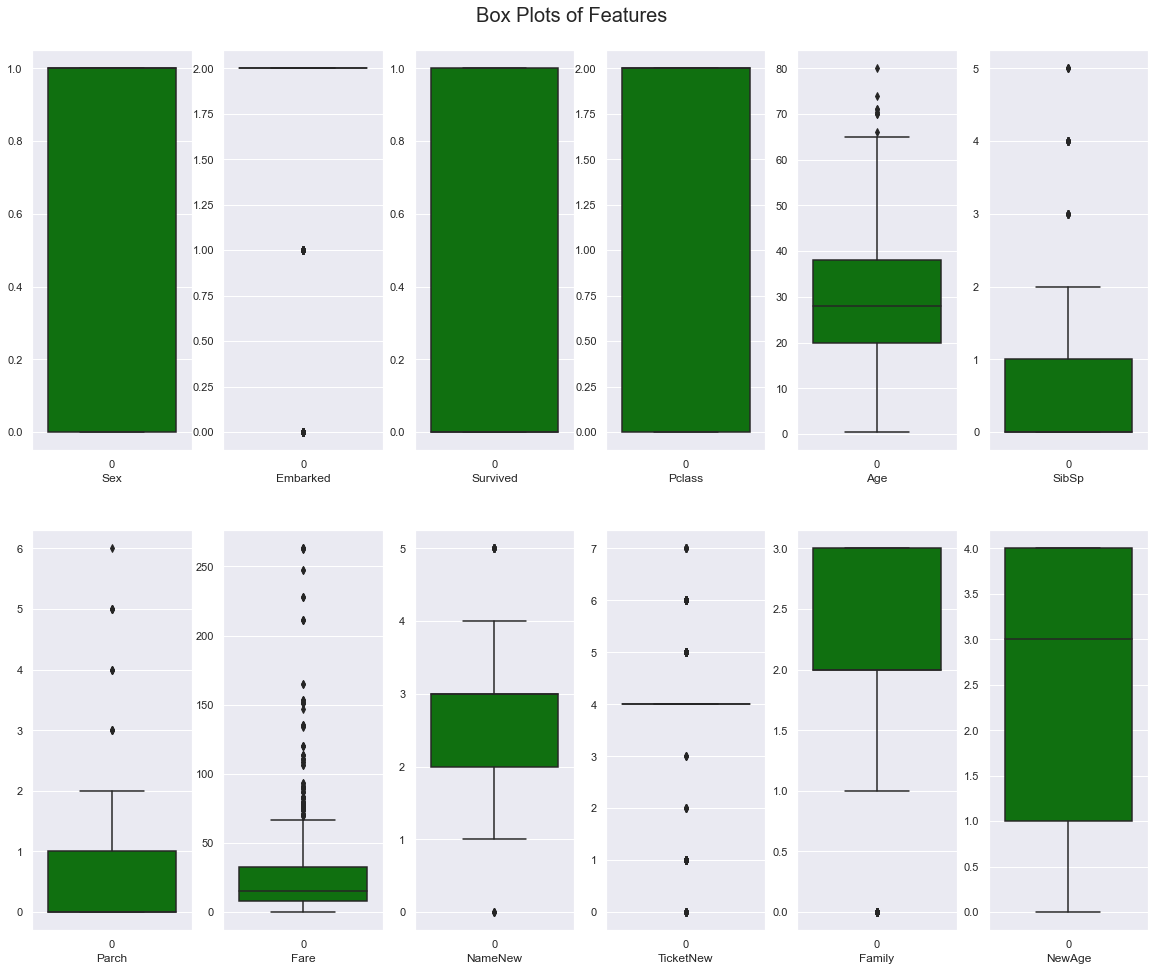

In [811]:
sns.set(rc={'figure.figsize':(20, 15)})
cols = 6
rows = round(train_df_reduced_outl.shape[1]/cols)
fig, ax = plt.subplots(rows, cols)
fig.suptitle('Box Plots of Features', fontsize = 20)
fig.subplots_adjust(top = 0.94)
for var, subplot in zip(train_df_reduced_outl, ax.flatten()):
    p = sns.boxplot(data = train_df_reduced_outl[var], color = 'green', ax = subplot)
    p.set_xlabel(var, fontsize = 12)

#### Check for duplicates

In [812]:
dupl_check = train_df_outl[train_df_outl.duplicated()]
dupl_check1 = train_df_reduced_outl[train_df_reduced_outl.duplicated()]

In [813]:
dupl_check

,SibSp,Parch,Fare,Sex,Embarked,Survived,Pclass,NameNew,TicketNew,Family
21,0,0,13.0000,1,2,1,1,3,4,2
37,0,0,8.0500,1,2,0,2,3,0,2
44,0,0,7.8792,0,1,1,2,2,4,2
47,0,0,7.7500,0,1,1,2,2,4,2
55,0,0,35.5000,1,2,1,0,3,4,2
...,...,...,...,...,...,...,...,...,...,...
881,0,0,7.8958,1,2,0,2,3,4,2
883,0,0,10.5000,1,2,0,1,3,1,2
884,0,0,7.0500,1,2,0,2,3,6,2
886,0,0,13.0000,1,2,0,1,5,4,2


In [814]:
dupl_check1

,Sex,Embarked,Survived,Pclass,Age,SibSp,Parch,Fare,NameNew,TicketNew,Family,NewAge
133,0,2,1,1,29.00,1,0,26.0000,4,4,3,4
173,1,2,0,2,21.00,0,0,7.9250,3,6,2,4
213,1,2,0,1,30.00,0,0,13.0000,3,4,2,4
313,1,2,0,2,28.00,0,0,7.8958,3,4,2,4
320,1,2,0,2,22.00,0,0,7.2500,3,0,2,4
355,1,2,0,2,28.00,0,0,9.5000,3,4,2,4
418,1,2,0,1,30.00,0,0,13.0000,3,4,2,4
476,1,2,0,1,34.00,1,0,21.0000,3,4,3,1
494,1,2,0,2,21.00,0,0,8.0500,3,0,2,4
500,1,2,0,2,17.00,0,0,8.6625,3,4,2,4


### 2.2 Preprocessing of the Testing Dataset <a class="anchor" id="testdata"></a>

### 2.2.1 Numerical Features <a class="anchor" id="trnum"></a>  
We separate numerical features from categorical in order to preprocess them separately.

In [815]:
test_df_num = test_df.select_dtypes(include=[np.number])
test_df = test_df.drop([col for col in test_df_num], axis = 1)
test_df_num.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,34.5,0,0,7.8292
1,3,47.0,1,0,7.0000
2,2,62.0,0,0,9.6875
3,3,27.0,0,0,8.6625
4,3,22.0,1,1,12.2875


#### Check for negative values

In [816]:
print((test_df_num < 0).any())

Pclass    False
Age       False
SibSp     False
Parch     False
Fare      False
dtype: bool


#### 2.2.1.1 Missing values (NaNs) <a class="anchor" id="testnummisvals"></a> 
Let's find all missing values (NaNs) in all columns and think about the proper way to deal with those values.

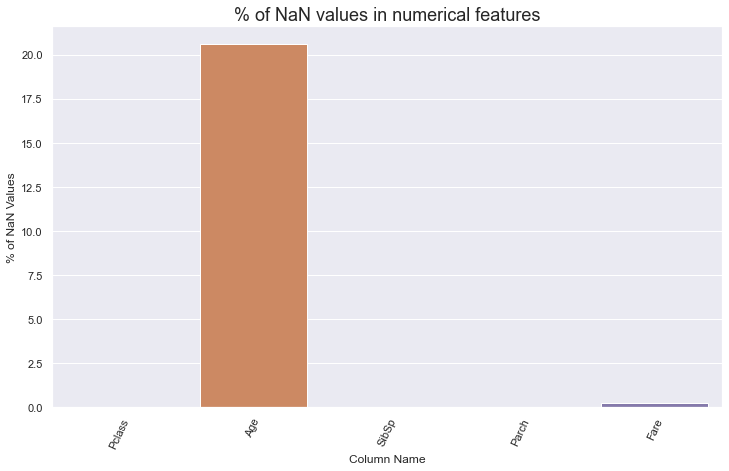

In [817]:
percent_missing_nans = test_df_num.isnull().sum() * 100 / len(test_df_num)
nans = pd.DataFrame({'col_name': test_df_num.columns, 'percent_missing': percent_missing_nans})

sns.set(rc={'figure.figsize':(12,7)})
cols = list(nans['col_name'])
percent = list(nans['percent_missing'])
plt.gca().set_ylabel('% of NaN Values', fontsize = 12)
plt.gca().set_xlabel('Column Name')
plt.title('% of NaN values in numerical features', fontsize = 18)
sns.barplot(x = cols, y = percent)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 65)
plt.show()

In [818]:
nans = nans.reset_index(drop = True)
missing_vals_cols = nans[nans['percent_missing'] != 0]
missing_vals_cols

,col_name,percent_missing
1,Age,20.574163
4,Fare,0.239234


#### Fare

In [819]:
imputer = KNNImputer(n_neighbors = 5, weights='distance', metric='nan_euclidean')

test_features_imputed = pd.DataFrame(imputer.fit_transform(test_df_num.loc[:, test_df_num.columns != 'Survived']))
test_features_imputed.columns = test_df_num.loc[:, test_df_num.columns != 'Survived'].columns

test_features_imputed1 = pd.DataFrame(imputer.fit_transform(test_df_num.loc[:, test_df_num.columns != 'Survived']))
test_features_imputed.columns = test_df_num.loc[:, test_df_num.columns != 'Survived'].columns

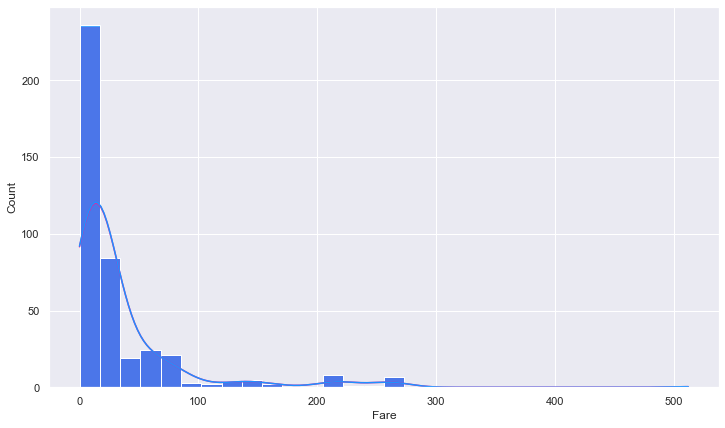

In [820]:
sns.set(rc={"figure.figsize": (12, 7)})
sns.histplot(x = test_df_num['Fare'], kde = True, bins = 30, color = 'deeppink', alpha = 1)
sns.histplot(x = test_features_imputed['Fare'], kde = True, bins = 30, color = 'dodgerblue', alpha = 0.8)
plt.show()

In [821]:
test_df_num['Fare'] = test_features_imputed['Fare']

In [822]:
# Full dataframe of both categorical and numerical features
full_data_temp = pd.concat([test_df, test_df_num], axis = 1)

#### Age

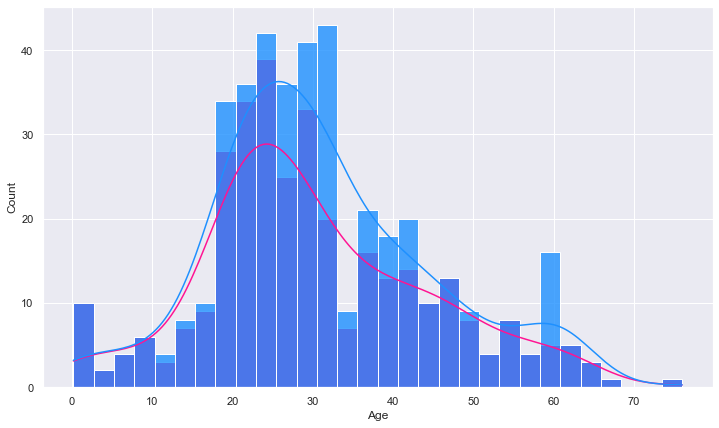

In [823]:
#test_df_reduced = full_data_temp[full_data_temp['Age'].notna()]
sns.set(rc={"figure.figsize": (12, 7)})
sns.histplot(x = test_df_num['Age'], kde = True, bins = 30, color = 'deeppink', alpha = 1)
sns.histplot(x = test_features_imputed['Age'], kde = True, bins = 30, color = 'dodgerblue', alpha = 0.8)
plt.show()

In [824]:
test_df_num = test_df_num.drop(columns=['Age'])

In [825]:
test_df_reduced = full_data_temp
test_df_reduced['Age'] = test_features_imputed['Age']

#### 2.2.1.2 Quasi Constants Check <a class="anchor" id="testquasiconst"></a> 

In [826]:
""" threshold = 0.05 means 95% of the values are constant
with thresholds < 0.05 i.e. 96% and above, no such columns where detected """

vt = VarianceThreshold(threshold = 0.05)
vt.fit(test_df_num.iloc[:,])

print(f"Number of features left: {sum(vt.get_support())}")
t_quasi_constant_features = [x for x in test_df_num.iloc[:, :-1].columns if x not in test_df_num.iloc[:,].columns[vt.get_support()]]
print(f"Number of quasi constant features to be dropped: {t_quasi_constant_features}")
#test_df_num = test_df_num.drop(t_quasi_constant_features, axis = 1)

Number of features left: 4
Number of quasi constant features to be dropped: []


No quasi-constant features were found among numerical variables.

#### 2.2.1.3 Category Change <a class="anchor" id="testnewcat"></a> 
Features such as the PassengerId, Survived, and Pclass are categorical, therefore, we will assign a corresponding type to those.
Other features such as SibSp, Parch, and Fare are numerical, therefore, we will assign a corresponding type to those.

In [827]:
for col in [['Pclass']]:
    test_df_num[col] = test_df_num[col].astype('object')
    test_df_reduced[col] = test_df_reduced[col].astype('object')

In [828]:
test_df = pd.concat([test_df, test_df_num], axis = 1)
test_df

,Name,Sex,Ticket,Cabin,Embarked,Pclass,SibSp,Parch,Fare
0,"Kelly, Mr. James",male,330911,NaN,Q,3,0,0,7.8292
1,"Wilkes, Mrs. James (Ellen Needs)",female,363272,NaN,S,3,1,0,7.0000
2,"Myles, Mr. Thomas Francis",male,240276,NaN,Q,2,0,0,9.6875
3,"Wirz, Mr. Albert",male,315154,NaN,S,3,0,0,8.6625
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,3101298,NaN,S,3,1,1,12.2875
...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",male,A.5. 3236,NaN,S,3,0,0,8.0500
414,"Oliva y Ocana, Dona. Fermina",female,PC 17758,C105,C,1,0,0,108.9000
415,"Saether, Mr. Simon Sivertsen",male,SOTON/O.Q. 3101262,NaN,S,3,0,0,7.2500
416,"Ware, Mr. Frederick",male,359309,NaN,S,3,0,0,8.0500


In [829]:
test_df_reduced

,Name,Sex,Ticket,Cabin,Embarked,Pclass,Age,SibSp,Parch,Fare
0,"Kelly, Mr. James",male,330911,NaN,Q,3,34.500000,0,0,7.8292
1,"Wilkes, Mrs. James (Ellen Needs)",female,363272,NaN,S,3,47.000000,1,0,7.0000
2,"Myles, Mr. Thomas Francis",male,240276,NaN,Q,2,62.000000,0,0,9.6875
3,"Wirz, Mr. Albert",male,315154,NaN,S,3,27.000000,0,0,8.6625
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,3101298,NaN,S,3,22.000000,1,1,12.2875
...,...,...,...,...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",male,A.5. 3236,NaN,S,3,25.800000,0,0,8.0500
414,"Oliva y Ocana, Dona. Fermina",female,PC 17758,C105,C,1,39.000000,0,0,108.9000
415,"Saether, Mr. Simon Sivertsen",male,SOTON/O.Q. 3101262,NaN,S,3,38.500000,0,0,7.2500
416,"Ware, Mr. Frederick",male,359309,NaN,S,3,25.800000,0,0,8.0500


### 2.2.2 Categorical Features <a class="anchor" id="testcat"></a>  
We separate categorical features from numerical in order to preprocess them separately.

In [830]:
test_df_cat = test_df.select_dtypes(include=[object])
test_df = test_df.drop([col for col in test_df_cat], axis = 1)
test_df_cat

,Name,Sex,Ticket,Cabin,Embarked,Pclass
0,"Kelly, Mr. James",male,330911,NaN,Q,3
1,"Wilkes, Mrs. James (Ellen Needs)",female,363272,NaN,S,3
2,"Myles, Mr. Thomas Francis",male,240276,NaN,Q,2
3,"Wirz, Mr. Albert",male,315154,NaN,S,3
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,3101298,NaN,S,3
...,...,...,...,...,...,...
413,"Spector, Mr. Woolf",male,A.5. 3236,NaN,S,3
414,"Oliva y Ocana, Dona. Fermina",female,PC 17758,C105,C,1
415,"Saether, Mr. Simon Sivertsen",male,SOTON/O.Q. 3101262,NaN,S,3
416,"Ware, Mr. Frederick",male,359309,NaN,S,3


#### 2.2.2.1 Missing values (NaNs) <a class="anchor" id="testcatmisvals"></a> 
Let's find all missing values (NaNs) in all columns and think about the proper way to deal with those values.

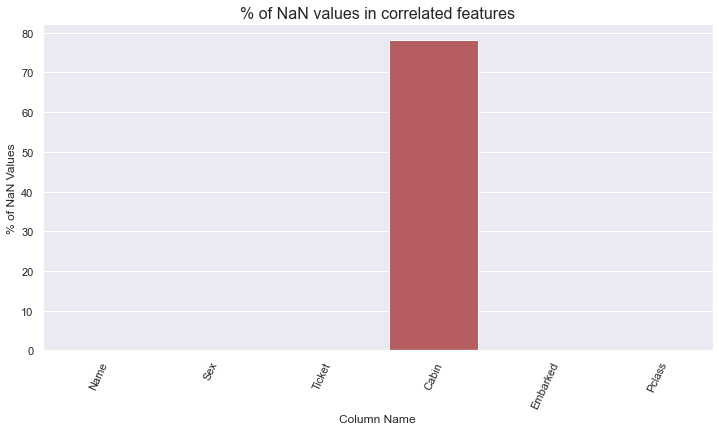

In [831]:
percent_missing_nans = test_df_cat.isnull().sum() * 100 / len(test_df_cat)
nans = pd.DataFrame({'col_name': test_df_cat.columns, 'percent_missing': percent_missing_nans})

sns.set(rc={'figure.figsize':(12,6)})
cols = list(nans['col_name'])
percent = list(nans['percent_missing'])
plt.gca().set_ylabel('% of NaN Values', fontsize = 12)
plt.gca().set_xlabel('Column Name')
plt.title('% of NaN values in correlated features', fontsize = 16)
sns.barplot(x = cols, y = percent)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 65)
plt.show()

In [832]:
nans = nans.reset_index(drop = True)
missing_vals_cols = nans[nans['percent_missing'] != 0]
missing_vals_cols

,col_name,percent_missing
3,Cabin,78.229665


#### Cabin

In [833]:
test_df_cat.drop('Cabin', axis = 1, inplace=True)
test_df_reduced.drop('Cabin', axis = 1, inplace=True)

### 2.2.3 Simplification of Features <a class="anchor" id="testfreqcat"></a>  
We pursue two tasks here: 1) eliminate all categories with less than 5 observations, 2) eliminate unecessary large number of categories, for examle 5 or 7, if applicable 3) encode features after modifications done according to 1) and 2)

In [834]:
test_df = pd.concat([test_df, test_df_cat], axis = 1)
test_df

,SibSp,Parch,Fare,Name,Sex,Ticket,Embarked,Pclass
0,0,0,7.8292,"Kelly, Mr. James",male,330911,Q,3
1,1,0,7.0000,"Wilkes, Mrs. James (Ellen Needs)",female,363272,S,3
2,0,0,9.6875,"Myles, Mr. Thomas Francis",male,240276,Q,2
3,0,0,8.6625,"Wirz, Mr. Albert",male,315154,S,3
4,1,1,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,3101298,S,3
...,...,...,...,...,...,...,...,...
413,0,0,8.0500,"Spector, Mr. Woolf",male,A.5. 3236,S,3
414,0,0,108.9000,"Oliva y Ocana, Dona. Fermina",female,PC 17758,C,1
415,0,0,7.2500,"Saether, Mr. Simon Sivertsen",male,SOTON/O.Q. 3101262,S,3
416,0,0,8.0500,"Ware, Mr. Frederick",male,359309,S,3


#### Show the frequencies of all categories in each feature

In [835]:
for c in test_df_cat.columns:
    print('--------', c, '--------')
    print(test_df_cat[c].value_counts())

-------- Name --------
Kelly, Mr. James               1
Carr, Miss. Jeannie            1
Dennis, Mr. William            1
Rosblom, Miss. Salli Helena    1
Touma, Miss. Maria Youssef     1
                              ..
Zakarian, Mr. Mapriededer      1
Carlsson, Mr. Carl Robert      1
Dintcheff, Mr. Valtcho         1
Thomas, Mr. Charles P          1
Peter, Master. Michael J       1
Name: Name, Length: 418, dtype: int64
-------- Sex --------
male      266
female    152
Name: Sex, dtype: int64
-------- Ticket --------
PC 17608    5
CA. 2343    4
113503      4
PC 17483    3
220845      3
           ..
349226      1
2621        1
4133        1
113780      1
2668        1
Name: Ticket, Length: 363, dtype: int64
-------- Embarked --------
S    270
C    102
Q     46
Name: Embarked, dtype: int64
-------- Pclass --------
3    218
1    107
2     93
Name: Pclass, dtype: int64


#### Name

In [836]:
firstName = test_df.Name.str.split(".").str.get(0).str.split(",").str.get(-1)
firstName1 = test_df_reduced.Name.str.split(".").str.get(0).str.split(",").str.get(-1)
firstName.value_counts()

 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Col         2
 Rev         2
 Ms          1
 Dr          1
 Dona        1
Name: Name, dtype: int64

In [837]:
firstName.replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Officer", inplace = True, regex = True)
firstName.replace(to_replace = ["Dona", "Jonkheer", "Countess", "Sir", "Lady", "Don"], value = "Aristocrat", inplace = True, regex = True)
firstName.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace = True, regex = True)
firstName.replace({"the Aristocrat":"Aristocrat"}, inplace = True, regex = True)
test_df["NameNew"] = firstName


firstName1.replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Officer", inplace = True, regex = True)
firstName1.replace(to_replace = ["Dona", "Jonkheer", "Countess", "Sir", "Lady", "Don"], value = "Aristocrat", inplace = True, regex = True)
firstName1.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace = True, regex = True)
firstName1.replace({"the Aristocrat":"Aristocrat"}, inplace = True, regex = True)
test_df_reduced["NameNew"] = firstName1

#### Tickets

In [838]:
temp = test_df.Ticket.str.split(" ").str.get(0).str.get(0)
test_df["TicketNew"] = np.where(test_df.Ticket.str.isdigit(), "N", temp)

temp1 = test_df_reduced.Ticket.str.split(" ").str.get(0).str.get(0)
test_df_reduced["TicketNew"] = np.where(test_df_reduced.Ticket.str.isdigit(), "N", temp1)

test_df.TicketNew.value_counts()

N    296
S     33
P     33
C     30
A     13
W      6
F      6
L      1
Name: TicketNew, dtype: int64

#### SibSp and Parch

In [839]:
test_df["Family"] = test_df.SibSp + test_df.Parch + 1
test_df_reduced["Family"] = test_df_reduced.SibSp + test_df_reduced.Parch + 1
test_df.Family.value_counts()

1     253
2      74
3      57
4      14
5       7
7       4
11      4
6       3
8       2
Name: Family, dtype: int64

In [840]:
test_df.Family.replace(to_replace = [1], value = "single", inplace = True)
test_df.Family.replace(to_replace = [2, 3], value = "small", inplace = True)
test_df.Family.replace(to_replace = [4,5], value = "medium", inplace = True)
test_df.Family.replace(to_replace = [6, 7, 8, 11], value = "large", inplace = True)

test_df_reduced.Family.replace(to_replace = [1], value = "single", inplace = True)
test_df_reduced.Family.replace(to_replace = [2, 3], value = "small", inplace = True)
test_df_reduced.Family.replace(to_replace = [4,5], value = "medium", inplace = True)
test_df_reduced.Family.replace(to_replace = [6, 7, 8, 11], value = "large", inplace = True)

In [841]:
test_df_reduced['NewAge'] = test_df_reduced.apply(age_func, axis = 1)

In [842]:
test_df

,SibSp,Parch,Fare,Name,Sex,Ticket,Embarked,Pclass,NameNew,TicketNew,Family
0,0,0,7.8292,"Kelly, Mr. James",male,330911,Q,3,Mr,N,single
1,1,0,7.0000,"Wilkes, Mrs. James (Ellen Needs)",female,363272,S,3,Mrs,N,small
2,0,0,9.6875,"Myles, Mr. Thomas Francis",male,240276,Q,2,Mr,N,single
3,0,0,8.6625,"Wirz, Mr. Albert",male,315154,S,3,Mr,N,single
4,1,1,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,3101298,S,3,Mrs,N,small
...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,8.0500,"Spector, Mr. Woolf",male,A.5. 3236,S,3,Mr,A,single
414,0,0,108.9000,"Oliva y Ocana, Dona. Fermina",female,PC 17758,C,1,Aristocrat,P,single
415,0,0,7.2500,"Saether, Mr. Simon Sivertsen",male,SOTON/O.Q. 3101262,S,3,Mr,S,single
416,0,0,8.0500,"Ware, Mr. Frederick",male,359309,S,3,Mr,N,single


In [843]:
test_df1 = test_df.copy()
test_df_reduced1 = test_df_reduced.copy()
test_df.drop('Name', axis = 1, inplace=True)
test_df.drop('Ticket', axis = 1, inplace=True)

test_df_reduced.drop('Name', axis = 1, inplace=True)
test_df_reduced.drop('Ticket', axis = 1, inplace=True)

### 2.2.4  Label encoding/factorizing <a class="anchor" id="testencvals"></a> 

In [844]:
test_df_reduced

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare,NameNew,TicketNew,Family,NewAge
0,male,Q,3,34.500000,0,0,7.8292,Mr,N,single,middle-aged adult
1,female,S,3,47.000000,1,0,7.0000,Mrs,N,small,old adult
2,male,Q,2,62.000000,0,0,9.6875,Mr,N,single,old adult
3,male,S,3,27.000000,0,0,8.6625,Mr,N,single,young adult
4,female,S,3,22.000000,1,1,12.2875,Mrs,N,small,young adult
...,...,...,...,...,...,...,...,...,...,...,...
413,male,S,3,25.800000,0,0,8.0500,Mr,A,single,young adult
414,female,C,1,39.000000,0,0,108.9000,Aristocrat,P,single,middle-aged adult
415,male,S,3,38.500000,0,0,7.2500,Mr,S,single,middle-aged adult
416,male,S,3,25.800000,0,0,8.0500,Mr,N,single,young adult


In [845]:
test_df_cat = test_df.select_dtypes(include=['object'])
test_df = DfLabelEncoder(columns = test_df_cat.columns).fit_transform(test_df)

test_df_cat1 = test_df_reduced.select_dtypes(include=['object'])
test_df_reduced = DfLabelEncoder(columns = test_df_cat1.columns).fit_transform(test_df_reduced)

In [846]:
for col in [['Sex', 'Embarked', 'Pclass', 'NameNew', 'TicketNew', 'Family', 'SibSp', 'Parch']]:
    test_df[col] = test_df[col].astype('object')

for col in [['Sex', 'Embarked', 'Pclass', 'NameNew', 'TicketNew', 'Family', 'NewAge', 'SibSp', 'Parch']]:
    test_df_reduced[col] = test_df_reduced[col].astype('object')

In [847]:
test_df

,SibSp,Parch,Fare,Sex,Embarked,Pclass,NameNew,TicketNew,Family
0,0,0,7.8292,1,1,2,3,4,2
1,1,0,7.0000,0,2,2,4,4,3
2,0,0,9.6875,1,1,1,3,4,2
3,0,0,8.6625,1,2,2,3,4,2
4,1,1,12.2875,0,2,2,4,4,3
...,...,...,...,...,...,...,...,...,...
413,0,0,8.0500,1,2,2,3,0,2
414,0,0,108.9000,0,0,0,0,5,2
415,0,0,7.2500,1,2,2,3,6,2
416,0,0,8.0500,1,2,2,3,4,2


In [848]:
test_df_reduced

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare,NameNew,TicketNew,Family,NewAge
0,1,1,2,34.500000,0,0,7.8292,3,4,2,1
1,0,2,2,47.000000,1,0,7.0000,4,4,3,2
2,1,1,1,62.000000,0,0,9.6875,3,4,2,2
3,1,2,2,27.000000,0,0,8.6625,3,4,2,4
4,0,2,2,22.000000,1,1,12.2875,4,4,3,4
...,...,...,...,...,...,...,...,...,...,...,...
413,1,2,2,25.800000,0,0,8.0500,3,0,2,4
414,0,0,0,39.000000,0,0,108.9000,0,5,2,1
415,1,2,2,38.500000,0,0,7.2500,3,6,2,1
416,1,2,2,25.800000,0,0,8.0500,3,4,2,4


#### Train/test splits

In [849]:
y_tr = train_df_outl['Survived']
y_tr1 = train_df_reduced_outl['Survived']

X_tr = train_df_outl.loc[:, ~train_df_outl.columns.isin(['Survived'])]
X_tr1 = train_df_reduced_outl.loc[:, ~train_df_reduced_outl.columns.isin(['Survived'])]

X_ts = test_df
X_ts1 = test_df_reduced

X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size = 0.2, random_state = 30, stratify = y_tr)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tr1, y_tr1, test_size = 0.2, random_state = 30, stratify = y_tr1)

### 2.2.5 Feature Importance <a class="anchor" id="ftimp"></a>

#### Full train dataset

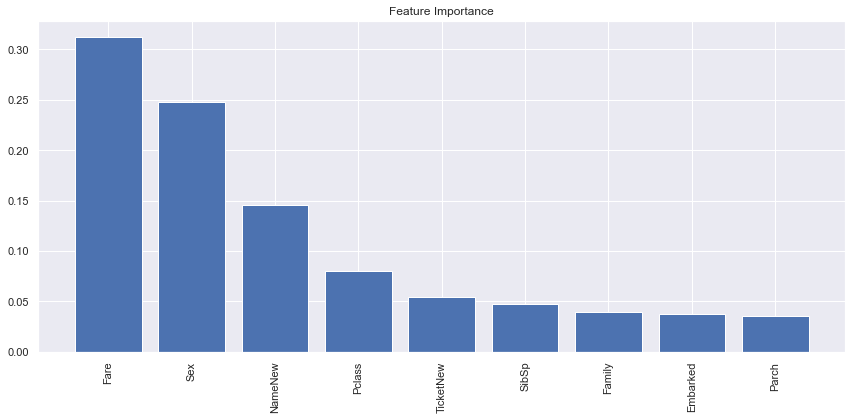

In [850]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train.values.ravel())
importances = forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_df_outl.columns[1:]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

#### Reduced train dataset

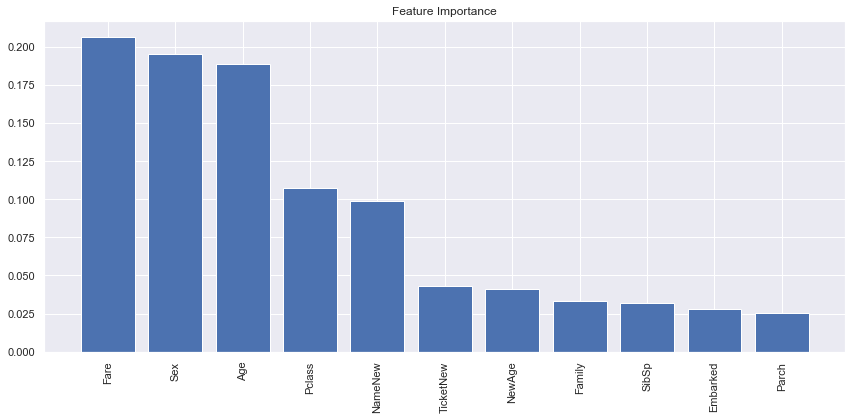

In [851]:
forest.fit(X_train1, y_train1.values.ravel())
importances = forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feat_labels = train_df_reduced_outl.columns[1:]

plt.title('Feature Importance')
plt.bar(range(X_train1.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train1.shape[1]), X_train1.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [852]:
X_train1 = X_train1.drop(columns=['NewAge'])
X_test1 = X_test1.drop(columns=['NewAge'])
X_tr1 = X_tr1.drop(columns=['NewAge'])
X_ts1 = X_ts1.drop(columns=['NewAge'])

## 3 Classification Modeling <a class="anchor" id="modeling"></a>

### 3.1.1 Random Forest <a class="anchor" id="rf"></a>

In [853]:
param_grid = { 
    'randomforestclassifier__n_estimators': [ 200, 300],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__max_depth' : [6,7,8],
    'randomforestclassifier__criterion' :('gini', 'entropy')}

In [854]:
rfc = RandomForestClassifier(random_state=0)
steps = [('scaler', RobustScaler()), ('randomforestclassifier', rfc)]
pipeline = Pipeline(steps)
CV_rfc = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_rfc.fit(X_tr1, y_tr1)
CV_rfc.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 8,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 200}

In [855]:
rfc1 = RandomForestClassifier(random_state = 0, n_estimators = 300, criterion = 'gini', max_features = 'auto', max_depth = 6)
steps = [('scaler', RobustScaler()), ('randomforestclassifier', rfc1)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
pipeline.score(X_tr1, y_tr1)
acc_random_forest = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_random_forest

88.01

### 3.1.2 Perceptron <a class="anchor" id="pr"></a>

In [856]:
param_grid = { 
    'perceptron__penalty': ['l2', 'l1', 'elasticnet'],
    'perceptron__alpha': [0.0001, 0.0005, 0.005],
    'perceptron__l1_ratio' : [0.15, 0.5, 0.10],
    'perceptron__tol' :[1e-2, 1e-3, 1e-4]
}

In [857]:
pc = Perceptron(random_state = 0)
steps = [('scaler', RobustScaler()), ('perceptron', pc)]
pipeline = Pipeline(steps)
CV_pc = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_pc.fit(X_tr1, y_tr1)
CV_pc.best_params_

{'perceptron__alpha': 0.0005,
 'perceptron__l1_ratio': 0.15,
 'perceptron__penalty': 'elasticnet',
 'perceptron__tol': 0.01}

In [858]:
pc1 = Perceptron(alpha = 0.005, l1_ratio = 0.15, penalty = 'elasticnet', tol = 0.01)
steps = [('scaler', RobustScaler()), ('perceptron', pc1)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_perceptron = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_perceptron

71.79

### 3.1.3 Support Vector Machines (SVC) <a class="anchor" id="svc"></a>

In [859]:
param_grid = { 
    'svc__kernel': ['linear', 'poly', 'rbg'],
    'svc__degree': [1, 2],
    'svc__gamma' : ['scale', 'auto'],
    'svc__tol' :[1e-2, 1e-3, 1e-4]
}

In [860]:
svc = SVC(random_state = 0)
steps = [('scaler', RobustScaler()), ('svc', svc)]
pipeline = Pipeline(steps)
CV_svc = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_svc.fit(X_tr1, y_tr1)
CV_svc.best_params_

{'svc__degree': 2,
 'svc__gamma': 'auto',
 'svc__kernel': 'poly',
 'svc__tol': 0.01}

In [861]:
svc1 = SVC(degree = 2, gamma = 'auto', kernel = 'poly', tol = 0.01, probability = True)
steps = [('scaler', RobustScaler()), ('svc', svc1)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_svc1 = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_svc1

81.38

### 3.1.4 Linear SVC <a class="anchor" id="linsvc"></a>

In [862]:
param_grid = { 
    'svcl__penalty': ['l2', 'l1'],
    'svcl__loss': ['hinge', 'squared_hinge'],
    'svcl__tol' :[1e-2, 1e-3, 1e-4]
}

In [863]:
svcl = LinearSVC(random_state = 0)
steps = [('scaler', RobustScaler()), ('svcl', svcl)]
pipeline = Pipeline(steps)
CV_svcl = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_svcl.fit(X_tr1, y_tr1)
CV_svcl.best_params_

{'svcl__loss': 'squared_hinge', 'svcl__penalty': 'l2', 'svcl__tol': 0.01}

In [864]:
svcl1 = LinearSVC(loss = 'squared_hinge', penalty = 'l2', tol = 0.01)
steps = [('scaler', RobustScaler()), ('svcl', svcl1)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_svcl = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_svcl

80.25

### 3.1.5 KNN <a class="anchor" id="knn"></a>

In [865]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train1, y_train1)
    pred_i = knn.predict(X_test1)
    error_rate.append(np.mean(pred_i != y_test1))

Minimum error:- 0.33098591549295775 at K = 22


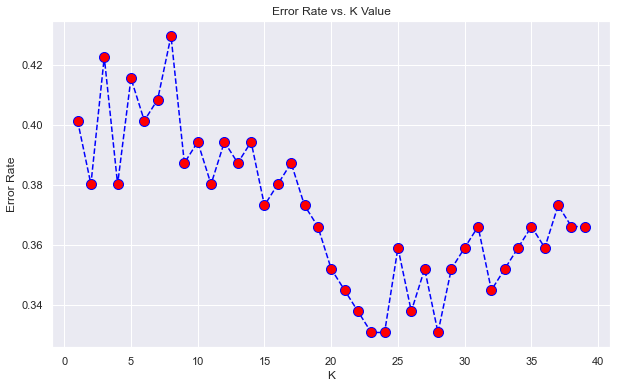

In [866]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate, color='blue', linestyle='dashed', 
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [867]:
knn = KNeighborsClassifier(n_neighbors = 6)
steps = [('scaler', RobustScaler()), ('knn', knn)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_knn = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_knn

83.36

### 3.1.6 Stochastic Gradient Descent <a class="anchor" id="sgd"></a>

In [868]:
param_grid = { 
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge'],
    'sgd__alpha' :[1e-2, 1e-3, 1e-4, 1e-5],
    'sgd__l1_ratio': [0.15, 0.2, 0.3]
}

In [869]:
sgd = SGDClassifier(random_state = 0)
steps = [('scaler', RobustScaler()), ('sgd', sgd)]
pipeline = Pipeline(steps)
CV_sgd = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_sgd.fit(X_tr1, y_tr1)
CV_sgd.best_params_

{'sgd__alpha': 0.01,
 'sgd__l1_ratio': 0.2,
 'sgd__loss': 'modified_huber',
 'sgd__penalty': 'elasticnet'}

In [870]:
sgd1 = SGDClassifier(alpha = 0.01, l1_ratio = 0.15, loss = 'modified_huber', penalty = 'l1', random_state = 0)
steps = [('scaler', RobustScaler()), ('sgd', sgd1)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_sgd = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_sgd

79.69

### 3.1.7 Decision Tree <a class="anchor" id="dectree"></a>

In [871]:
param_grid = { 
    'dt__criterion': ['gini', 'entropy', 'log_loss'],
    'dt__splitter' : ['best', 'random']
}

In [872]:
dt = DecisionTreeClassifier(random_state = 0)
steps = [('scaler', RobustScaler()), ('dt', dt)]
pipeline = Pipeline(steps)
CV_dt = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_dt.fit(X_tr1, y_tr1)
CV_dt.best_params_

{'dt__criterion': 'entropy', 'dt__splitter': 'best'}

In [873]:
dt1 = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best')
steps = [('scaler', RobustScaler()), ('dt', dt1)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_dt = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_dt

99.44

### 3.2.8 Gaussian Naive Bayes <a class="anchor" id="nb"></a>

In [874]:
param_grid = { 
    'nb__var_smoothing': [1e-7, 1e-8, 1e-9]
}

In [875]:
nb = GaussianNB()
steps = [('scaler', RobustScaler()), ('nb', nb)]
pipeline = Pipeline(steps)
CV_nb = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_nb.fit(X_tr1, y_tr1)
CV_nb.best_params_

{'nb__var_smoothing': 1e-07}

In [876]:
gaussian = GaussianNB(var_smoothing = 1e-07)
steps = [('scaler', RobustScaler()), ('gaussian', gaussian)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_gaussian = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_gaussian

78.42

### 3.1.9 Logistic Regression <a class="anchor" id="lr"></a>

In [877]:
param_grid = { 
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'lr__tol': [1e-3, 1e-4, 1e-5]
}

In [878]:
lr = LogisticRegression()
steps = [('scaler', RobustScaler()), ('lr', lr)]
pipeline = Pipeline(steps)
CV_lr = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5)
CV_lr.fit(X_tr1, y_tr1)
CV_lr.best_params_

{'lr__penalty': 'l2', 'lr__tol': 0.001}

In [879]:
lr1 = LogisticRegression(penalty = 'none', tol = 0.001, random_state = 0)
steps = [('scaler', RobustScaler()), ('lr1', lr1)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)
Y_pred = pipeline.predict(X_ts1)
acc_lr = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_lr

80.39

### 3.1.10 Ensemble <a class="anchor" id="ens"></a>

In [886]:
from sklearn.ensemble import VotingClassifier
voter = VotingClassifier(estimators=[('lr1', lr1), ('dt1', dt1),
('sgd1', sgd1), ('knn', knn),('rfc1', rfc1)], voting = 'soft', n_jobs = 4)
steps = [('scaler', RobustScaler()), ('voter', voter)]
pipeline = Pipeline(steps)
pipeline.fit(X_tr1, y_tr1)

Pipeline(steps=[('scaler', RobustScaler()),
                ('voter',
                 VotingClassifier(estimators=[('svc1',
                                               SVC(degree=2, gamma='auto',
                                                   kernel='poly',
                                                   probability=True,
                                                   tol=0.01)),
                                              ('dt1',
                                               DecisionTreeClassifier(criterion='entropy')),
                                              ('sgd1',
                                               SGDClassifier(alpha=0.01,
                                                             loss='modified_huber',
                                                             penalty='l1',
                                                             random_state=0)),
                                              ('knn',
                                   

In [887]:
acc_vt = round(pipeline.score(X_tr1, y_tr1) * 100, 2)
acc_vt

91.68

In [882]:
y_pred = pipeline.predict(X_ts1)

[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0
 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 1]


In [883]:
import csv

df = pd.DataFrame(
    {'PassengerId': test_id_col,
     'Survived': y_pred,
    })

df.to_csv('dt.csv', index = False)